In [95]:
from rpy2 import robjects
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import matplotlib.dates as mdates
import pandas as pd
import numpy as np
import datetime
import yaml
import os

# Convert pandas dataframe
from rpy2.robjects import pandas2ri
pandas2ri.activate()

output_dir = 'output_13-24-mob/'
#output_dir = 'output/'

dept_avail = os.listdir(output_dir)


rainfall = pd.read_csv('haiti-data/fromAzman/rainfall.csv', index_col = 0, parse_dates = True)
cases    = pd.read_csv('haiti-data/fromAzman/cases_corrected.csv', index_col=0, parse_dates =True)


compartments = ['S', 'I', 'A', 'RA1', 'RA2', 'RA3', 'RI1', 'RI2', 'RI3', 'W', 'B', 'cases', 
                 "VSd", "VRI1d", "VRI2d", "VRI3d", "VRA1d", "VRA2d", "VRA3d",
                 "VSdd", "VRI1dd", "VRI2dd", "VRI3dd", "VRA1dd", "VRA2dd", "VRA3dd",
                 "VSd_alt", "VRI1d_alt", "VRI2d_alt", "VRI3d_alt", "VRA1d_alt", "VRA2d_alt", "VRA3d_alt",
                 "VSdd_alt", "VRI1dd_alt", "VRI2dd_alt", "VRI3dd_alt", "VRA1dd_alt", "VRA2dd_alt", "VRA3dd_alt"]

stream = open('haiti-data/input_parameters.yaml', 'r')
input_parameters = yaml.load(stream)

dept_name = [list(pop.keys())[0] for pop in input_parameters['population']]

t_start = input_parameters['t_start']
t_for = datetime.date(2029,12,21)

# computes precipitation sample
def project_rain(rainfall, tf):
    nd = 14 #days sampled - must be multiple of 7 d
    
    dti = rainfall.iloc[0].name.date()
    dtf = rainfall.iloc[-1].name.date()
    
    rain_prj_index = pd.DatetimeIndex(start =  dtf + datetime.timedelta(1), 
                                      end = tf, freq = 'D')
    rain_prj = np.zeros((rain_prj_index.shape[0], 10))

    # Full years of data available
    years = range(dti.year+1, dtf.year-1)

    # each nd days, assign an al precipitation.
    for i, date in enumerate(pd.date_range(dtf + datetime.timedelta(1), tf, freq = str(nd)+'D')):
        dd = date.day
        if (date.month == 2 and dd == 29):
            dd = 28
        pick = datetime.date(np.random.choice(years), date.month, dd)
        #print(pick, i, rainfall.loc[pd.date_range(pick, pick + datetime.timedelta(nd-1))].values.shape, rain_prj[nd * i: nd * (i+1)].shape)
        rain_prj[nd * i: nd * (i+1)] = rainfall.loc[pd.date_range(pick, pick + datetime.timedelta(nd-1))].values

    rain_prj = pd.DataFrame(rain_prj, index = rain_prj_index, columns = dept_name)
    
    return rain_prj

rain_prj = project_rain(rainfall, t_for)
rain = pd.concat((rainfall, rain_prj))
rain.to_csv('haiti-data/proj/rainfall.csv', index_label = 'date')

In [102]:
nsim = 1
run_lvl = 3

### Extracting best performing parameters

In [103]:
index = pd.DatetimeIndex(start =  t_start,  end = t_for, freq = 'W-SAT')
r_source = robjects.r['source'];

covar_init = pd.concat([cases]*3, ignore_index=True)[0:-206]
covar_init.index = pd.DatetimeIndex(start =  datetime.date(2010,10,23), 
                                      end = t_for, freq = 'W-SAT')
covar_init.to_csv('covar_mob.csv', index_label='date')

all_data = {}
#all_params = {}
for i, dp in enumerate(dept_avail):
    dept_data = {}
    robjects.r('departement <- "' + dp + '"')
    robjects.r('output_dir <- "' + output_dir + '"')
    robjects.r('run_level <- ' + str(run_lvl))
    robjects.r('nsim <- ' + str(nsim))
    #robjects.r('cases_ext <- 456') 
    robjects.r('t_vacc_start <- "' + str('2010-01-01') + '"')
    robjects.r('t_vacc_end  <- "' + str('2010-01-01') + '"')
    robjects.r('p1d_reg <- 0') 
    robjects.r('r_v_year <- 0')
    print(dp)
    r_source('~/phd/haiti-ocv-pomp/scripts/forecast_haitiOCV_mob.R')
    if i == 0:
        all_params = pd.DataFrame(np.zeros((len(dept_avail), len(robjects.r('names(params)')))),  columns = robjects.r('names(params)'), index = dept_avail)        
    all_params.loc[dp] = robjects.r['params']
    for comp in compartments:
        temp = pandas2ri.ri2py(robjects.r[comp])
        temp.index = index
        temp.drop('date',axis=1, inplace = True)
        dept_data[comp] = temp
    all_data[dp] = dept_data
    #all_params[dp] = params

# Convert years in days, 'mu', 'alpha'
rates = [ "gammaI", "gammaA", "rhoA", 'rhoI', 'mu_B']
params_disp = all_params.copy()
params_disp.loc[:,'rhoI'] = params_disp.loc[:,'XrhoI'] * params_disp.loc[:,'rhoA']
params_disp.loc[:,'thetaA'] = params_disp.loc[:,'XthetaA'] * params_disp.loc[:,'thetaI']
params_disp.drop(['mu', 'alpha', 'XrhoI', 'XthetaA', 't_vacc_start', 't_vacc_end', 'p1d_reg', 'r_v_year', 'H', 'D', 'Rtot_0'], axis =1, inplace = True)
print(params_disp)
for p in rates:
    params_disp.loc[:,p] =  1/(params_disp.loc[:,p]/365.25)
    
params_disp = params_disp.reindex(columns=sorted(params_disp.columns))

Nord-Ouest
Grande_Anse
Nippes
Sud-Est
Centre
Artibonite
Nord-Est
Ouest
Nord
Sud
                sigma     betaB        mu_B    thetaI   lambdaR         r  \
Nord-Ouest   0.665137  0.624407  880.527328  0.000606  0.147036  0.391351   
Grande_Anse  0.665137  0.624407  880.527328  0.000606  0.147036  0.391351   
Nippes       0.665137  0.624407  880.527328  0.000606  0.147036  0.391351   
Sud-Est      0.665137  0.624407  880.527328  0.000606  0.147036  0.391351   
Centre       0.665137  0.624407  880.527328  0.000606  0.147036  0.391351   
Artibonite   0.665137  0.624407  880.527328  0.000606  0.147036  0.391351   
Nord-Est     0.665137  0.624407  880.527328  0.000606  0.147036  0.391351   
Ouest        0.665137  0.624407  880.527328  0.000606  0.147036  0.391351   
Nord         0.665137  0.624407  880.527328  0.000606  0.147036  0.391351   
Sud          0.665137  0.624407  880.527328  0.000606  0.147036  0.391351   

              gammaI   gammaA       rhoA       foi_add   epsilon        

In [ ]:
all_params.loc['Artibonite']

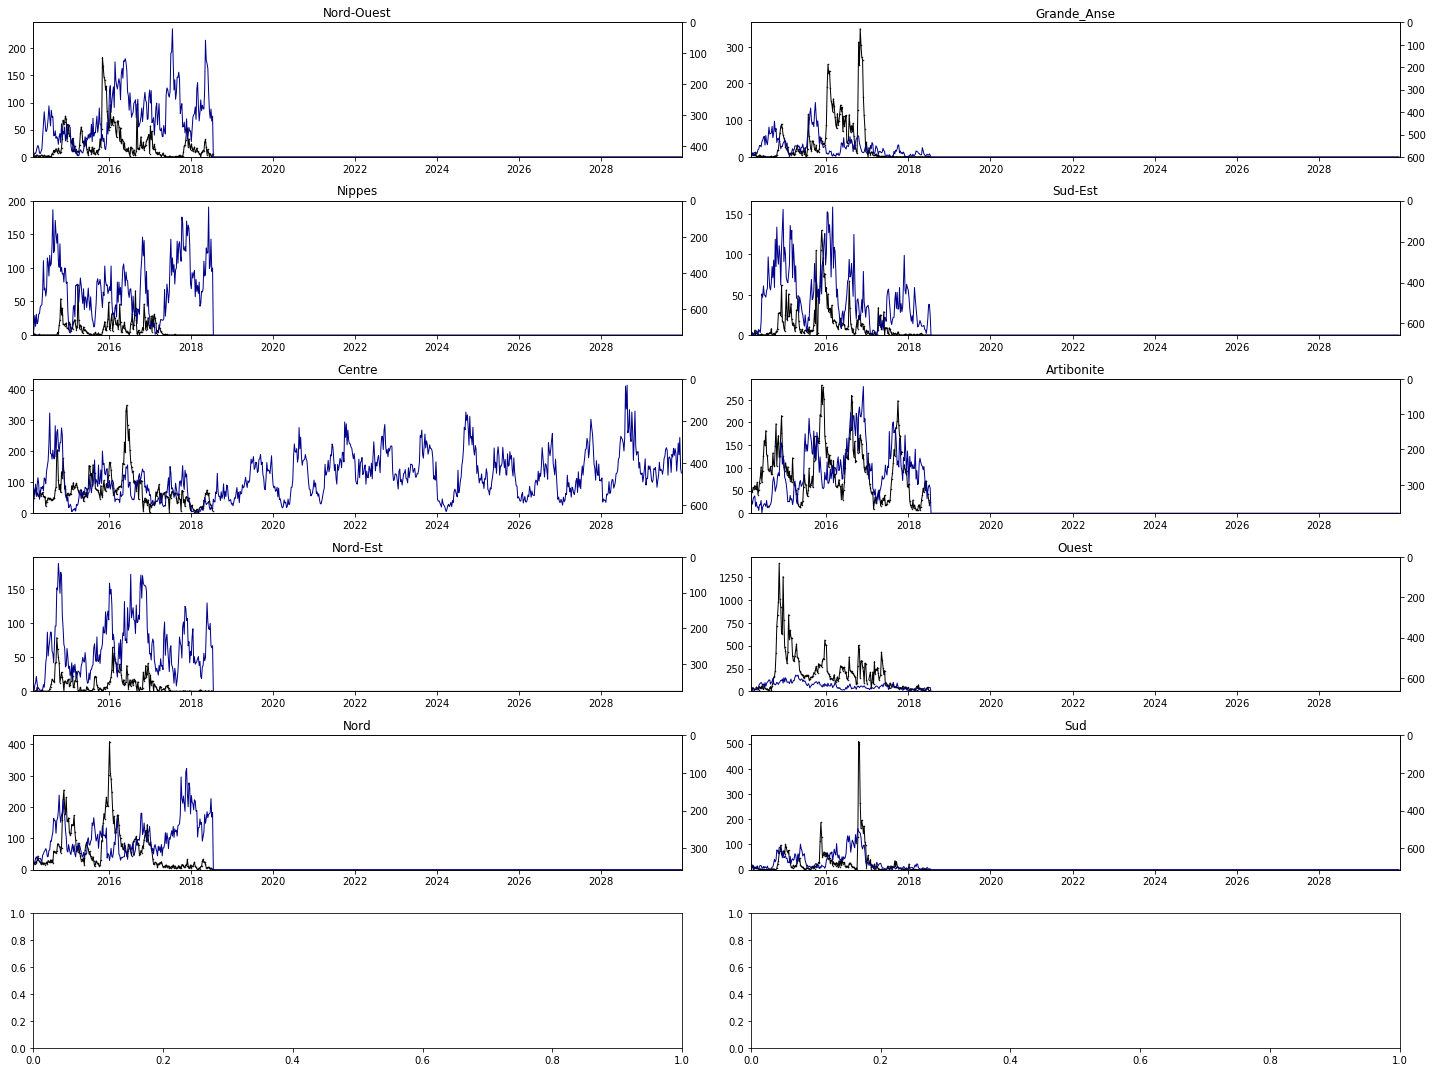

In [104]:
ti = input_parameters['t_start']
tf = t_for#datetime.date(2018,7,21)

fig, axes = plt.subplots((len(all_data))//2+1, 2, figsize=(20,15), squeeze = True);
fig.patch.set_facecolor('white')
axes = axes.flatten();
for i, dp in enumerate(dept_avail):
    axt =  axes[i].twinx()
    axes[i].plot(cases[dp][t_start:][ti:tf], marker='.', linestyle='-',color='k', linewidth=1, markersize=1 ) 
    axes[i].fill_between(all_data[dp]['cases']['q05'][ti:tf].index, all_data[dp]['cases']['q05'][ti:tf], all_data[dp]['cases']['q95'][ti:tf], alpha = .5, color = 'red', linewidth = 0)
    #axes[i].plot(all_data[dp]['cases']['mean'], linewidth=1, alpha = 1,linestyle='-.', color = 'black')
    axes[i].plot(all_data[dp]['cases']['q50'][ti:tf], alpha = 1,linestyle='-', linewidth = 1, color = 'darkblue')
    #axt.bar(pd.date_range(t_start,t_for, freq='W-SAT')[ti:tf].date, rain[dp].resample('W-SAT').sum()[t_start:t_for][ti:tf], 
    #            label = r'Rainfall', color = 'darkblue', width=7, alpha = 1)

    axes[i].set_title(dp)
    axes[i].set_ylim(0)
    axt.set_ylim(2*max(rain[dp].resample('W-SAT').sum()[t_start:t_for]),0) # check if only reverse y
    axes[i].set_xlim(ti, tf)
    #axes[i].legend()
    
fig.tight_layout()

In [ ]:
import seaborn as sns
sns.pairplot(params_disp, markers = '.')

In [ ]:
dp = 'Artibonite'
fig, axes = plt.subplots((len(compartments))//4, 4, figsize=(15,15), squeeze = True);
axes = axes.flatten();
for i, comp in enumerate(compartments):
    axes[i].fill_between(all_data[dp][comp]['q05'].index, all_data[dp][comp]['q05'], all_data[dp][comp]['q95'], alpha = .5, color = 'red', linewidth = 0)
    axes[i].plot(all_data[dp][comp]['mean'], linewidth=1, alpha = 1,linestyle='-.', color = 'black')
    axes[i].plot(all_data[dp][comp]['q50'], alpha = 1,linestyle='-', linewidth = 1, color = 'blue') 
    axes[i].set_title(comp)
    axes[i].legend()
    axes[i].set_ylim(0)
    
fig.tight_layout()

In [34]:
class VaccinationScenario():

    def __init__(self, course_year, percent_completely_unvaccinated, percent_onedose, percent_twodoses, not_dep = []):
        pop = {'Artibonite':1727524,
        'Centre':746236,
        'Grande_Anse':468301,
        'Nippes':342525,
        'Nord':1067177,
        'Nord-Est':393967,
        'Nord-Ouest':728807,
        'Ouest':4029705,
        'Sud':774976,
        'Sud-Est':632601}

        ocv_order = ['Centre', 'Artibonite','Ouest','Nord-Ouest','Nord','Sud', 'Nippes','Nord-Est', 'Sud-Est','Grande_Anse']


        self.t_vacc_start = {}
        self.t_vacc_end = {}
        self.p1d_reg = {}
        self.r_v_year = {}

        #20% completely unvaccinated, 10% one-dose only, 70% two doses

        t_init = datetime.date(2018,7,14)
        days_per_departement = int((course_year*365)/len(ocv_order))

        for i, dp in enumerate(ocv_order):
            if dp not in not_dep:
                self.t_vacc_start[dp] = t_init + datetime.timedelta(days=i*days_per_departement)
                self.t_vacc_end[dp] = t_init + datetime.timedelta(days=(i+1)*days_per_departement)
                self.p1d_reg[dp] = percent_onedose/(percent_onedose + percent_twodoses)
                self.r_v_year[dp] = pop[dp]*(100-percent_completely_unvaccinated)/100/days_per_departement * 365.25

            else:
                self.t_vacc_start[dp] = t_init + datetime.timedelta(days=i*days_per_departement)
                self.t_vacc_end[dp] = t_init + datetime.timedelta(days=(i+1)*days_per_departement)
                self.p1d_reg[dp] = 0
                self.r_v_year[dp] =0



S1 = VaccinationScenario(2, 20, 10, 70)
S2 = VaccinationScenario(2, 40, 20, 40, not_dep=['Ouest','Nord-Ouest','Sud', 'Nippes','Nord-Est', 'Sud-Est','Grande_Anse'])
S3 = VaccinationScenario(5, 3.33, 1.67, 95)

In [75]:
# Running simulation:
scenario = S1
index = pd.DatetimeIndex(start =  t_start,  end = t_for, freq = 'W-SAT')
r_source = robjects.r['source'];

all_data_vacc = {}
for i, dp in enumerate(dept_avail):
    dept_data = {}
    robjects.r('departement <- "' + dp + '"')
    robjects.r('output_dir <- "' + output_dir + '"')
    robjects.r('run_level <- ' + str(run_lvl))
    robjects.r('nsim <- ' + str(nsim))
    
    robjects.r('t_vacc_start <- "' + str(scenario.t_vacc_start[dp]) + '"')
    robjects.r('t_vacc_end  <- "' + str(scenario.t_vacc_end[dp]) + '"')
    robjects.r('p1d_reg <- ' + str(scenario.p1d_reg[dp]))
    robjects.r('r_v_year <- ' + str(scenario.r_v_year[dp]))

    r_source('~/phd/haiti-ocv-pomp/scripts/forecast_haitiOCV.R')
  
    for comp in compartments:
        temp = pandas2ri.ri2py(robjects.r[comp])
        temp.index = index
        temp.drop('date',axis=1, inplace = True)
        dept_data[comp] = temp
    all_data_vacc[dp] = dept_data
    #all_params[dp] = params

RRuntimeError: Error: in 'simulate': variable 'cases_covar_c' not found among the covariates


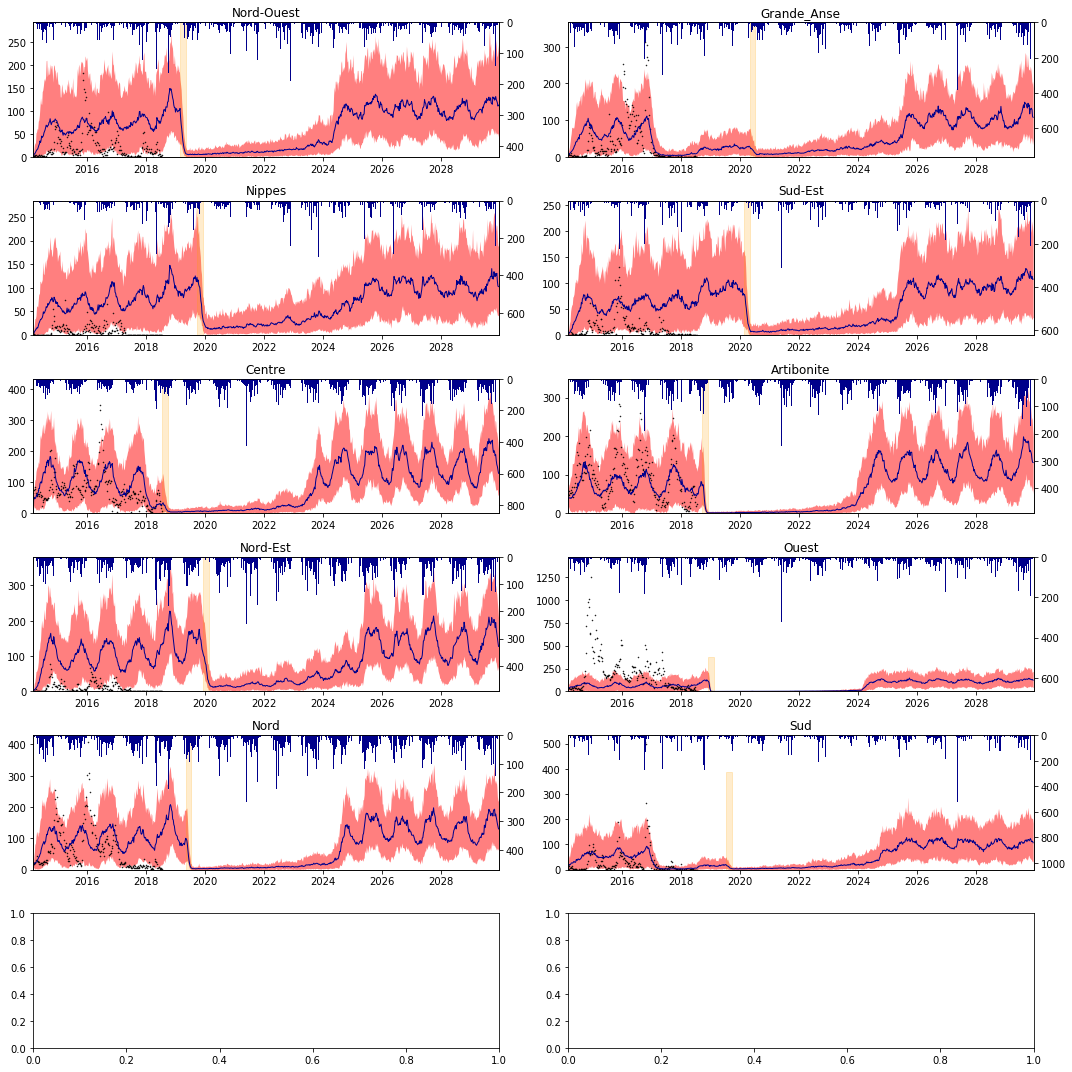

In [38]:
fig, axes = plt.subplots((len(all_data))//2+1, 2, figsize=(15,15), squeeze = True);
axes = axes.flatten();
fig.patch.set_facecolor('white')


for i, dp in enumerate(dept_avail):
    axt =  axes[i].twinx()
    axes[i].plot(cases[dp][t_start:], marker='.', linestyle='-',color='k', linewidth=0, markersize=1 ) 
    axes[i].fill_between(all_data_vacc[dp]['cases']['q05'].index, all_data_vacc[dp]['cases']['q05'], all_data_vacc[dp]['cases']['q95'], alpha = .5, color = 'red', linewidth = 0)
    axes[i].plot(all_data_vacc[dp]['cases']['q50'], alpha = 1,linestyle='-', linewidth = 1, color = 'darkblue')
    axt.bar(pd.date_range(t_start,t_for, freq='W-SAT').date, rain[dp].resample('W-SAT').sum()[t_start:t_for], 
                label = r'Rainfall', color = 'darkblue', width=7, alpha = 1)

    axes[i].set_title(dp)
    axes[i].set_ylim(0)
    axt.set_ylim(2*max(rain[dp].resample('W-SAT').sum()[t_start:t_for]),0) # check if only reverse y
    axes[i].set_xlim(t_start, t_for)
    #axes[i].legend()
    

    # convert to matplotlib date representation
    start = mdates.date2num(scenario.t_vacc_start[dp])
    end = mdates.date2num(scenario.t_vacc_end[dp])
    width = end - start
    rect = Rectangle((start, 0), width, 100+max(all_data_vacc[dp]['cases']['q95']), color='orange', alpha= 0.1)
    axes[i].add_patch(rect) 
    axes[i].add_artist(rect)
    rx, ry = rect.get_xy()
    cx = rx + rect.get_width()/2.0
    cy = ry + rect.get_height()/1.5
    #axes[i].annotate(r'Vaccination', (cx, cy), color='black',# weight='bold', 
    #            fontsize=12, ha='center', va='center', rotation='vertical')

fig.tight_layout()

In [ ]:
dp = 'Sud'


fig, axes = plt.subplots((len(compartments))//4, 4, figsize=(15,15), squeeze = True);
axes = axes.flatten();
for i, comp in enumerate(compartments):
    axes[i].fill_between(all_data_vacc[dp][comp]['q05'][ti:tf].index, all_data_vacc[dp][comp]['q05'][ti:tf], all_data_vacc[dp][comp]['q95'][ti:tf], alpha = .5, color = 'red', linewidth = 0)
    axes[i].plot(all_data_vacc[dp][comp]['mean'][ti:tf], linewidth=1, alpha = 1,linestyle='-.', color = 'black')
    axes[i].plot(all_data_vacc[dp][comp]['q50'][ti:tf], alpha = 1,linestyle='-', linewidth = 1, color = 'blue') 
    axes[i].set_title(comp)
    axes[i].legend()
    axes[i].set_ylim(0)
    
fig.tight_layout()

### Projection with mobility

In [76]:
# Running simulation:
scenario = S1
index = pd.DatetimeIndex(start =  t_start,  end = t_for, freq = 'W-SAT')
r_source = robjects.r['source'];

csv_all =  pd.DataFrame(0, index = pd.DatetimeIndex(start =  t_start, 
                                      end = t_for, freq = 'W-SAT'), columns = dept_name)


for i in range(10):
    print(i,)
    all_data_vacc = {}
    for i, dp in enumerate(dept_avail):
        dept_data = {}
        robjects.r('departement <- "' + dp + '"')
        robjects.r('output_dir <- "' + output_dir + '"')
        robjects.r('run_level <- ' + str(run_lvl))
        robjects.r('nsim <- ' + str(nsim))
    
        robjects.r('t_vacc_start <- "' + str(scenario.t_vacc_start[dp]) + '"')
        robjects.r('t_vacc_end  <- "' + str(scenario.t_vacc_end[dp]) + '"')
        robjects.r('p1d_reg <- ' + str(scenario.p1d_reg[dp]))
        robjects.r('r_v_year <- ' + str(scenario.r_v_year[dp]))

        r_source('~/phd/haiti-ocv-pomp/scripts/forecast_haitiOCV_mob.R')
  
        for comp in compartments:
            temp = pandas2ri.ri2py(robjects.r[comp])
            temp.index = index
            temp.drop('date',axis=1, inplace = True)
            dept_data[comp] = temp
        all_data_vacc[dp] = dept_data
    
        csv_all[dp] = all_data_vacc[dp]['cases']['q50']
        
    csv_all.to_csv('covar_mob.csv', index_label='date')

0


/usr/lib/python3.7/site-packages/rpy2/robjects/pandas2ri.py:191: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.
  res = PandasDataFrame.from_items(items)
/usr/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: Parsed with column specification:
cols(
  .default = col_double(),
  loglik.se = col_character(),
  H = col_integer(),
  cases_ext = col_integer(),
  t_vacc_start = col_integer(),
  t_vacc_end = col_integer(),
  p1d_reg = col_integer(),
  r_v_year = col_integer()
)

  warnings.warn(x, RRuntimeWarning)
/usr/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: Joining, by = c("loglik", "loglik.se", "betaB", "lambdaR", "r", "foi_add", "sigma", "mu_B", "thetaI", "XthetaA", "gammaI", "gammaA", "rhoA", "XrhoI", "epsilon", "k", "std_W", "Rtot_0", "H", "D", "mu", "alpha", "cases_ext", "t_vacc_start", "t_vacc

1


/usr/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: Parsed with column specification:
cols(
  date = col_date(format = ""),
  Artibonite = col_double(),
  Centre = col_integer(),
  Grande_Anse = col_integer(),
  Nippes = col_integer(),
  Nord = col_integer(),
  `Nord-Est` = col_integer(),
  `Nord-Ouest` = col_integer(),
  Ouest = col_integer(),
  Sud = col_double(),
  `Sud-Est` = col_integer()
)

  warnings.warn(x, RRuntimeWarning)


2
3
4
5
6

|
=====
                                                                   
|
   8%

|
                                                             
|
  16%

|
                                                       
|
  24%

|
                                                 
|
  32%

|
                                           
|
  40%

|
                                     
|
  48%

|
                              
|
  58%

|
                       
|
  67%

|
               
|
  75%    1 MB

|
          
|
  83%    1 MB

|
     
|
  91%    1 MB

|

|
 100%    1 MB


7
8
9


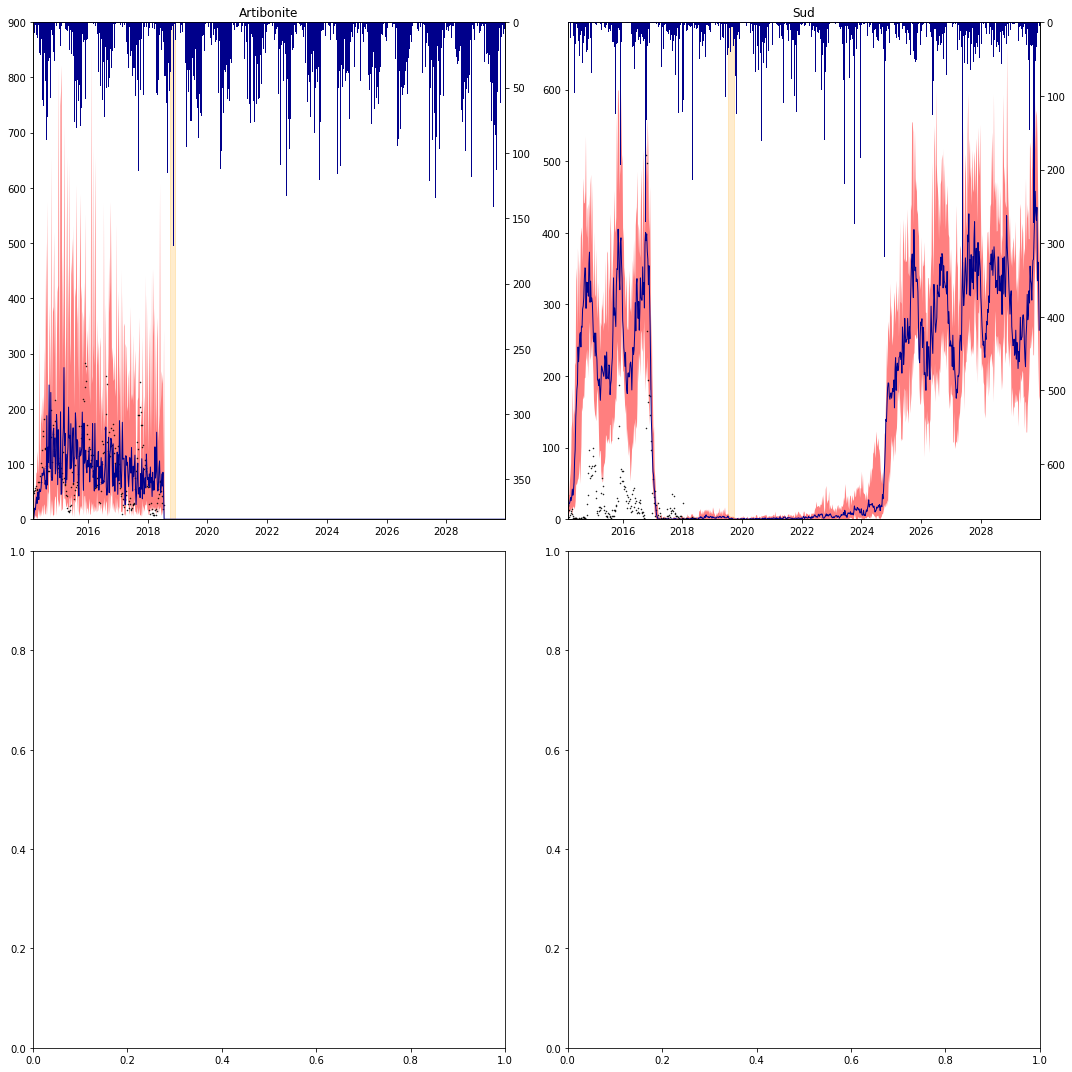

In [77]:
fig, axes = plt.subplots((len(all_data))//2+1, 2, figsize=(15,15), squeeze = True);
axes = axes.flatten();
fig.patch.set_facecolor('white')



for i, dp in enumerate(dept_avail):
    axt =  axes[i].twinx()
    axes[i].plot(cases[dp][t_start:], marker='.', linestyle='-',color='k', linewidth=0, markersize=1 ) 
    axes[i].fill_between(all_data_vacc[dp]['cases']['q05'].index, all_data_vacc[dp]['cases']['q05'], all_data_vacc[dp]['cases']['q95'], alpha = .5, color = 'red', linewidth = 0)
    axes[i].plot(all_data_vacc[dp]['cases']['q50'], alpha = 1,linestyle='-', linewidth = 1, color = 'darkblue')
    axt.bar(pd.date_range(t_start,t_for, freq='W-SAT').date, rain[dp].resample('W-SAT').sum()[t_start:t_for], 
                label = r'Rainfall', color = 'darkblue', width=7, alpha = 1)

    axes[i].set_title(dp)
    axes[i].set_ylim(0)
    axt.set_ylim(2*max(rain[dp].resample('W-SAT').sum()[t_start:t_for]),0) # check if only reverse y
    axes[i].set_xlim(t_start, t_for)
    #axes[i].legend()
    

    # convert to matplotlib date representation
    start = mdates.date2num(scenario.t_vacc_start[dp])
    end = mdates.date2num(scenario.t_vacc_end[dp])
    width = end - start
    rect = Rectangle((start, 0), width, 100+max(all_data_vacc[dp]['cases']['q95']), color='orange', alpha= 0.1)
    axes[i].add_patch(rect) 
    axes[i].add_artist(rect)
    rx, ry = rect.get_xy()
    cx = rx + rect.get_width()/2.0
    cy = ry + rect.get_height()/1.5
    #axes[i].annotate(r'Vaccination', (cx, cy), color='black',# weight='bold', 
    #            fontsize=12, ha='center', va='center', rotation='vertical')

fig.tight_layout()

In [68]:
csv_all =  pd.DataFrame(0, index = pd.DatetimeIndex(start =  t_start, 
                                      end = t_for, freq = 'W-SAT'), columns = dept_name)

csv_zero =  pd.DataFrame(0, index = pd.DatetimeIndex(start =  t_start, 
                                      end = t_for, freq = 'D'), columns = dept_name)
csv_zero.to_csv('covar_zero.csv', index_label='date')
for dp in dept_name:
    csv_all[dp] = all_data_vacc[dp]['cases']['q50']
csv_all.to_csv('covar_mob.csv', index_label='date')


In [88]:
covar_init = pd.concat([cases]*3, ignore_index=True)[0:-206]
covar_init.index = pd.DatetimeIndex(start =  datetime.date(2010,10,23), 
                                      end = t_for, freq = 'W-SAT')
covar_init.to_csv('covar_mob.csv', index_label='date')

In [90]:
cases

,Artibonite,Centre,Grande_Anse,Nippes,Nord,Nord-Est,Nord-Ouest,Ouest,Sud,Sud-Est
date,,,,,,,,,,
2010-10-23,6234.0,507,0,0,17,0,2,540.0,0,0
2010-10-30,7603.0,1245,0,0,145,0,518,1938.0,0,4
2010-11-06,4835.0,811,0,1,437,0,819,713.0,0,2
2010-11-13,8589.0,1247,0,0,1400,6,2243,3312.0,11,1
2010-11-20,7097.0,1750,25,10,2830,82,2592,7000.0,44,9
2010-11-27,5025.0,1460,143,24,4134,134,2241,5383.0,123,26
2010-12-04,3763.0,1442,668,37,3161,350,2005,5674.0,261,55
2010-12-11,2451.0,1385,1553,96,3037,470,1634,6733.0,533,494
2010-12-18,2429.0,1861,2703,251,3304,1445,1604,9777.0,1475,215
